# Arima & Sarima

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
df = pd.read_excel('/kaggle/input/dataflow/final.xlsx')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

In [4]:
df.drop(columns=["COGS", "Product", "State", "Unnamed: 0","Category", "Segment", "City", "Region", "District"])

,ProductID,Zip,Units,Revenue
Date,,,,
2010-07-04,604,47946,1,5767.65
2010-07-04,1859,20008,1,1877.40
2010-07-04,485,44830,1,10218.60
2010-07-04,485,55008,1,10218.60
2010-07-04,485,47380,1,10218.60
...,...,...,...,...
2022-07-01,2269,21012,1,4718.70
2022-07-01,2269,48313,1,4718.70
2022-07-01,465,40299,1,14174.37


In [6]:
monthly_revenue = df['Revenue'].resample('M').sum()

<ipython-input-6-0c7ab516aa7c>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_revenue = df['Revenue'].resample('M').sum()


In [7]:
def compute_metrics(actual, forecast):
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = np.mean(np.abs((actual - forecast) / (actual.replace(0, np.nan).fillna(1)))) * 100
    r2 = r2_score(actual, forecast)
    return rmse, mape, r2

## For testing arima

In [26]:
monthly_revenue = df['Units'].resample('M').sum()

<ipython-input-26-04b3367bf04c>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_revenue = df['Units'].resample('M').sum()


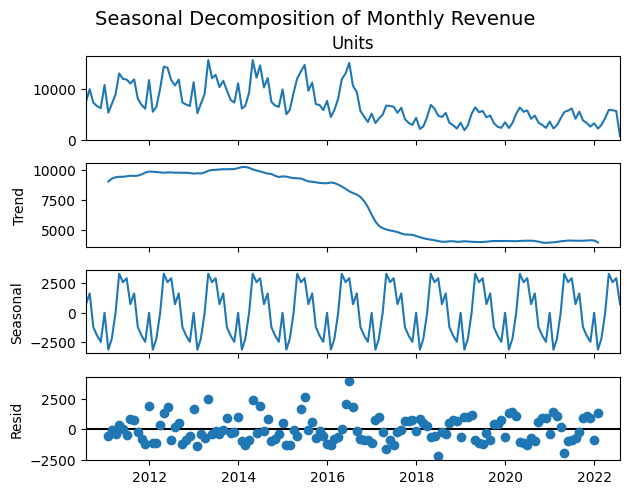

In [ ]:
# Check for Seasonality
decomp = sm.tsa.seasonal_decompose(monthly_revenue, model='additive')
decomp.plot()
plt.suptitle('Seasonal Decomposition of Monthly Revenue', fontsize=14, y=1.02)
plt.show()

In [10]:
# Check Stationarity (Dickey-Fuller Test)
result_adf = adfuller(monthly_revenue)
print("ADF Statistic: {:.4f}".format(result_adf[0]))
print("p-value: {:.4f}".format(result_adf[1]))
for key, value in result_adf[4].items():
    print('Critical Value ({}): {:.4f}'.format(key, value))


# H0: chuỗi không có tính dừng
# H1: chuỗi có tính dừng
# Do p-value > 0.05 nên chấp nhận H0, hay có cơ sở để nói rằng ko là chuỗi dừng`
# Repeat the process
# Do p-value < 0.05 nên bác bỏ H0, hay có cơ sở để nói rằng diff(revenue) là chuỗi dừng`

if result_adf[1] > 0.05:
    monthly_revenue_diff = monthly_revenue.diff().dropna()
    d = 1  
    print("\nSeries is non-stationary. Using first difference (d=1).")
else:
    monthly_revenue_diff = monthly_revenue
    d = 0
    print("\nSeries appears stationary. (d=0)")
    

ADF Statistic: -0.4402
p-value: 0.9032
Critical Value (1%): -3.4809
Critical Value (5%): -2.8837
Critical Value (10%): -2.5786

Series is non-stationary. Using first difference (d=1).


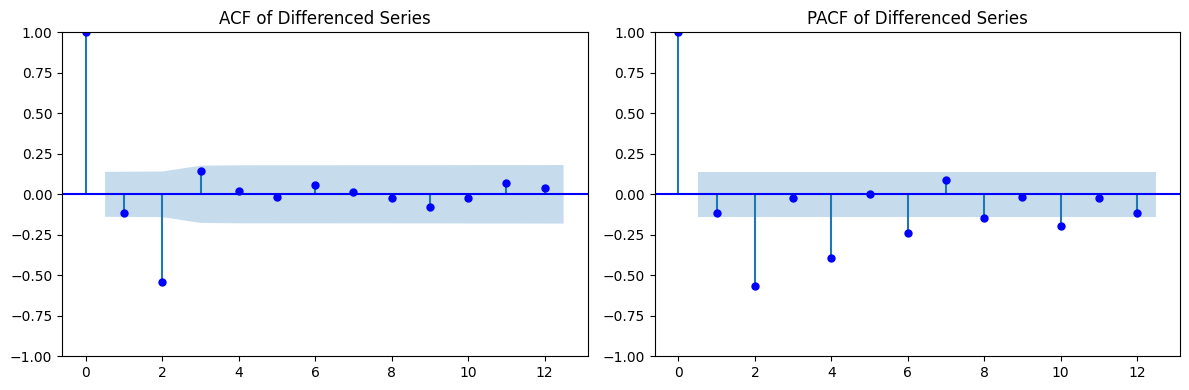

In [12]:
# Plot ACF PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(monthly_revenue_diff, ax=axes[0], lags=12)
axes[0].set_title('ACF of Differenced Series')
plot_pacf(monthly_revenue_diff, ax=axes[1], lags=12, method='ywm')
axes[1].set_title('PACF of Differenced Series')
plt.show()


In [ ]:
# Compute an EACF  (github)
def compute_eacf(time_series, d, max_p=5, max_q=5, alpha=0.05):
    """
    Computes a simplified EACF table over AR order (p) and MA order (q) for an ARIMA model.
    For each (p, q) (except (0,0)), the function fits an ARIMA model with order=(p,d,q)
    and checks whether all estimated coefficients (ignoring the constant) are insignificant.
    If yes, it marks 'O', otherwise 'X'. If the model fails to converge, NaN is recorded.
    """
    eacf_table = pd.DataFrame(index=range(max_p+1), columns=range(max_q+1))
    
    for p in range(max_p+1):
        for q in range(max_q+1):
            # Skiping (0,0)
            if p == 0 and q == 0:
                eacf_table.at[p, q] = '-'
                continue
            try:
                model = sm.tsa.ARIMA(time_series, order=(p, d, q)).fit(method_kwargs={"warn_convergence": False})
                params_pvalues = model.pvalues.drop('const', errors='ignore')
                if (params_pvalues > alpha).all():
                    eacf_table.at[p, q] = 'O'
                else:
                    eacf_table.at[p, q] = 'X'
            except Exception as e:
                eacf_table.at[p, q] = np.nan
    return eacf_table


In [31]:
eacf_table = compute_eacf(monthly_revenue_diff, d=d, max_p=5, max_q=5, alpha=0.05)
print("\nEACF Table (Rows: AR order p, Columns: MA order q):")
print(eacf_table)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.p


EACF Table (Rows: AR order p, Columns: MA order q):
   0  1  2  3  4  5
0  -  X  X  X  X  X
1  X  X  X  X  X  X
2  X  X  X  X  X  X
3  X  X  X  X  X  X
4  X  X  X  X  X  X
5  X  X  X  X  X  X


Comment: Cant tell anything

## training

THIS IS FOR REVENUE

In [5]:
!pip install pmdarima

In [14]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, r2_score
from pmdarima import auto_arima

In [15]:
train = monthly_revenue[monthly_revenue.index.year <= 2020]
test = monthly_revenue[monthly_revenue.index.year >= 2021]

In [16]:
def compute_metrics(actual, forecast):
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    r2 = r2_score(actual, forecast)
    return rmse, mape, r2

In [ ]:
# df = pd.read_excel('/kaggle/input/dataflow/final.xlsx')
# df['Date'] = pd.to_datetime(df['Date'])
# df = df.sort_values('Date')
# # Drop any unnecessary columns (adjust names as needed)
# df = df.drop(columns=["COGS", "Product", "State", "Unnamed: 0"], errors='ignore')
# df.head()

In [ ]:
# Model 1: ARIMA(3,1,3)
print("\nFitting ARIMA(3,1,3)...")
model_331 = sm.tsa.ARIMA(train, order=(3, 1, 3)).fit()
forecast_331 = model_331.forecast(steps=len(test))
rmse_331, mape_331, r2_331 = compute_metrics(test, forecast_331)
print("ARIMA(3,1,3) Metrics: RMSE={:.2f}, MAPE={:.2f}%, R²={:.2f}".format(rmse_331, mape_331, r2_331))



Fitting ARIMA(3,1,3)...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(3,1,3) Metrics: RMSE=9386847.10, MAPE=42.67%, R²=0.41


In [17]:
print("\nFitting ARIMA(1,1,1)...")
model_331 = sm.tsa.ARIMA(train, order=(1, 1, 1)).fit()
forecast_331 = model_331.forecast(steps=len(test))
rmse_331, mape_331, r2_331 = compute_metrics(test, forecast_331)
print("ARIMA(1,1,1) Metrics: RMSE={:.2f}, MAPE={:.2f}%, R²={:.2f}".format(rmse_331, mape_331, r2_331))



Fitting ARIMA(1,1,1)...
ARIMA(1,1,1) Metrics: RMSE=17017790.69, MAPE=47.92%, R²=-0.95


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
# Model 2: Optimal non-seasonal ARIMA via auto_arima
print("\nFitting Optimal non-seasonal ARIMA using auto_arima...")
auto_model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True,  stepwise=True)
print("Optimal non-seasonal ARIMA order:", auto_model.order)
forecast_auto = auto_model.predict(n_periods=len(test))
rmse_auto, mape_auto, r2_auto = compute_metrics(test, forecast_auto)
print("Optimal non-seasonal ARIMA Metrics: RMSE={:.2f}, MAPE={:.2f}%, R²={:.2f}".format(rmse_auto, mape_auto, r2_auto))



Fitting Optimal non-seasonal ARIMA using auto_arima...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2317.308, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2313.233, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2313.090, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2315.331, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2287.684, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2303.171, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2314.882, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2315.128, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2285.697, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2311.104, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2311.229, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2302.139, T

In [ ]:
# 7Model 3: Optimal Seasonal ARIMA via auto_arima (SARIMA)
print("\nFitting Optimal Seasonal ARIMA using auto_arima (seasonal=True)...")
auto_seasonal_model = auto_arima(train, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
print("Optimal Seasonal ARIMA order:", auto_seasonal_model.order,"Seasonal order:", auto_seasonal_model.seasonal_order)
forecast_seasonal = auto_seasonal_model.predict(n_periods=len(test))
rmse_seasonal, mape_seasonal, r2_seasonal = compute_metrics(test, forecast_seasonal)
print("Optimal Seasonal ARIMA Metrics: RMSE={:.2f}, MAPE={:.2f}%, R²={:.2f}".format(rmse_seasonal, mape_seasonal, r2_seasonal))



Fitting Optimal Seasonal ARIMA using auto_arima (seasonal=True)...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2181.954, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2317.308, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2162.519, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2229.660, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2315.331, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2313.233, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2163.902, Time=0.45 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2163.952, Time=0.37 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2229.826, Time=0.17 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2170.536, Time=0.22 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=2164.502, Time=0.26 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=2162.660, Time=0.47 sec
 ARIMA(0,1,1)(1,0,0)[12

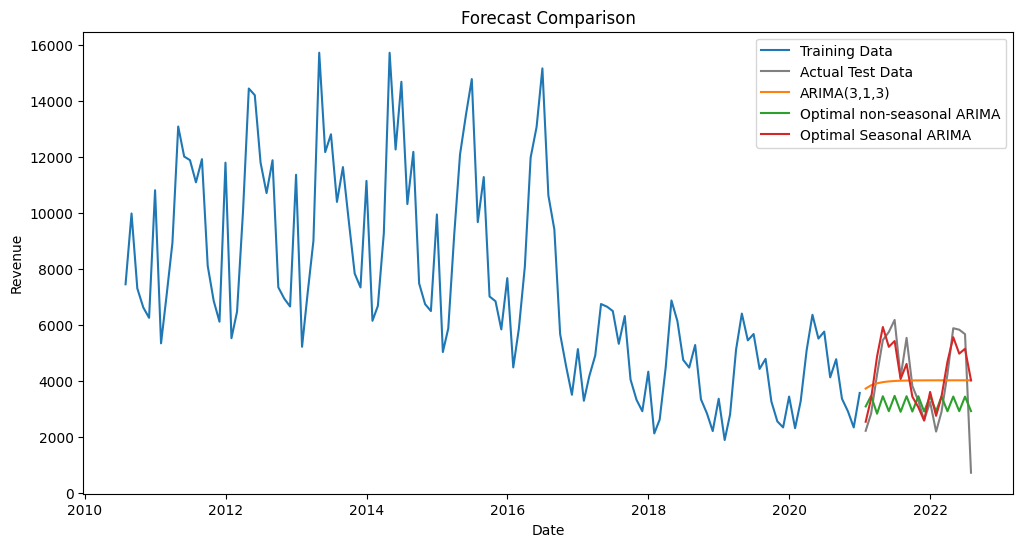

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Training Data")
plt.plot(test.index, test, label="Actual Test Data", color='gray')
plt.plot(test.index, forecast_331, label="ARIMA(3,1,3)")
plt.plot(test.index, forecast_auto, label="Optimal non-seasonal ARIMA")
plt.plot(test.index, forecast_seasonal, label="Optimal Seasonal ARIMA")
plt.title("Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.show()

In [44]:
print("\n=== Forecast Accuracy Comparison ===")
print("Model\t\t\tRMSE\tMAPE (%)\tR²")
print("ARIMA(3,1,3)\t\t{:.2f}\t{:.2f}\t\t{:.2f}".format(rmse_331, mape_331, r2_331))
print("Optimal non-seasonal ARIMA\t{:.2f}\t{:.2f}\t\t{:.2f}".format(rmse_auto, mape_auto, r2_auto))
print("Optimal Seasonal ARIMA\t{:.2f}\t{:.2f}\t\t{:.2f}".format(rmse_seasonal, mape_seasonal, r2_seasonal))


=== Forecast Accuracy Comparison ===
Model			RMSE	MAPE (%)	R²
ARIMA(3,1,3)		1524.78	53.99		0.02
Optimal non-seasonal ARIMA	1721.72	45.46		-0.25
Optimal Seasonal ARIMA	914.94	35.46		0.65


Now repeat the process again for Units

> 

## TIME SERRIES FINAL

In [14]:
monthly_sales = df['Units'].resample('M').sum()
monthly_revenue = df['Revenue'].resample('M').sum()

train_revenue = monthly_revenue[monthly_revenue.index.year <= 2020]
test_revenue  = monthly_revenue[monthly_revenue.index.year >= 2021]

train_sales = monthly_sales[monthly_sales.index.year <= 2020]
test_sales  = monthly_sales[monthly_sales.index.year >= 2021]

<ipython-input-14-e8caa14a252d>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['Units'].resample('M').sum()
<ipython-input-14-e8caa14a252d>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_revenue = df['Revenue'].resample('M').sum()


In [15]:
def compute_metrics(actual, forecast):
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    r2 = r2_score(actual, forecast)
    return rmse, mape, r2

In [16]:
def arima_forecasting(series_name, train_series, test_series):
    print(f"\n--- {series_name} Forecasting ---")
    decomp = sm.tsa.seasonal_decompose(train_series, model='additive')
    decomp.plot()
    plt.suptitle(f'{series_name} Seasonal Decomposition', fontsize=14)
    plt.show()
    result_adf = adfuller(train_series)
    print("ADF Statistic: {:.4f}, p-value: {:.4f}".format(result_adf[0], result_adf[1]))
    if result_adf[1] > 0.05:
        d = 1
        print("Series is non–stationary. Using first difference (d=1).")
    else:
        d = 0
        print("Series appears stationary. (d=0)")


    # Model 1: 
    print("\nFitting ARIMA(3,1,3)...")
    model_331 = sm.tsa.ARIMA(train_series, order=(3, 1, 3)).fit()
    forecast_331 = model_331.forecast(steps=len(test_series))
    rmse_331, mape_331, r2_331 = compute_metrics(test_series, forecast_331)
    print("ARIMA(3,1,3): RMSE={:.2f}, MAPE={:.2f}%, R²={:.2f}".format(rmse_331, mape_331, r2_331))
    
    # Model 2: 
    print("\nFitting Optimal non–seasonal ARIMA (auto_arima)...")
    auto_model = auto_arima(train_series, seasonal=False, trace=True,error_action='ignore', suppress_warnings=True, stepwise=True)
    print("Optimal non–seasonal ARIMA order:", auto_model.order)
    forecast_auto = auto_model.predict(n_periods=len(test_series))
    rmse_auto, mape_auto, r2_auto = compute_metrics(test_series, forecast_auto)
    print("Optimal non–seasonal ARIMA: RMSE={:.2f}, MAPE={:.2f}%, R²={:.2f}".format(rmse_auto, mape_auto, r2_auto))
    
    # Model 3: 
    print("\nFitting Optimal Seasonal ARIMA (auto_arima, seasonal=True)...")
    auto_seasonal_model = auto_arima(train_series, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
    print("Optimal Seasonal ARIMA order:", auto_seasonal_model.order,  "Seasonal order:", auto_seasonal_model.seasonal_order)
    forecast_seasonal = auto_seasonal_model.predict(n_periods=len(test_series))
    rmse_seasonal, mape_seasonal, r2_seasonal = compute_metrics(test_series, forecast_seasonal)
    print("Optimal Seasonal ARIMA: RMSE={:.2f}, MAPE={:.2f}%, R²={:.2f}".format(rmse_seasonal, mape_seasonal, r2_seasonal))
    
    plt.figure(figsize=(12,6))
    plt.plot(train_series.index, train_series, label="Training Data")
    plt.plot(test_series.index, test_series, label="Actual Test Data", color='gray')
    plt.plot(test_series.index, forecast_331, label="ARIMA(3,1,3)")
    plt.plot(test_series.index, forecast_auto, label="Optimal non–seasonal ARIMA")
    plt.plot(test_series.index, forecast_seasonal, label="Optimal Seasonal ARIMA")
    plt.title(f"{series_name} Forecast Comparison")
    plt.xlabel("Date")
    plt.ylabel(series_name)
    plt.legend()
    plt.show()
    
    return {
        'ARIMA(3,1,3)': (rmse_331, mape_331, r2_331),
        'Optimal non–seasonal ARIMA': (rmse_auto, mape_auto, r2_auto),
        'Optimal Seasonal ARIMA': (rmse_seasonal, mape_seasonal, r2_seasonal)
    }


>>> Sales (Units) ARIMA Forecasting

--- Sales (Units) Forecasting ---


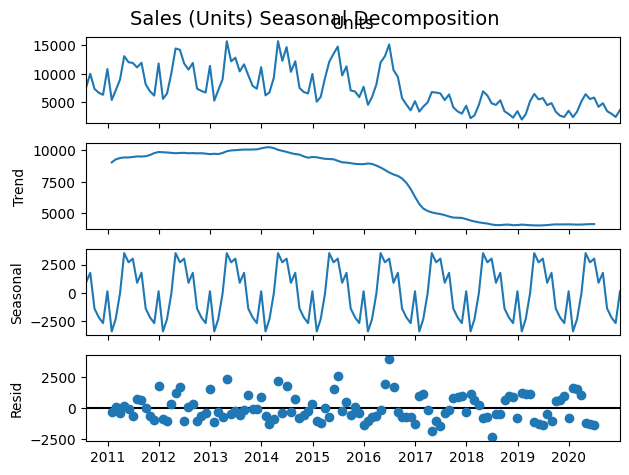

ADF Statistic: -0.4834, p-value: 0.8952
Series is non–stationary. Using first difference (d=1).

Fitting ARIMA(3,1,3)...


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3,1,3): RMSE=1448.97, MAPE=47.42%, R²=0.11

Fitting Optimal non–seasonal ARIMA (auto_arima)...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2317.308, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2313.233, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2313.090, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2315.331, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2287.684, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2303.171, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2314.882, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2315.128, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2285.697, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2311.104, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2311.229, Time=0.02 sec
 ARIMA(2

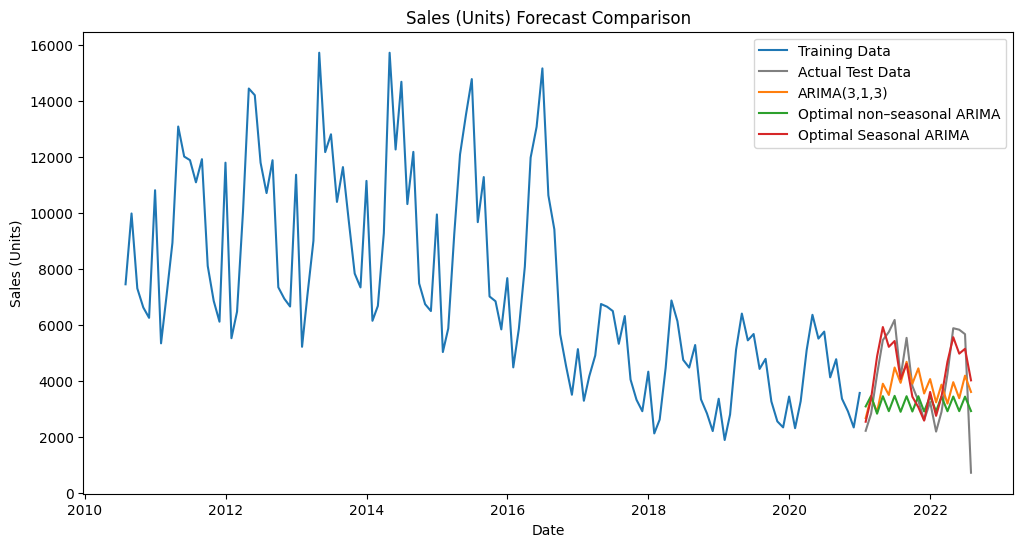

In [17]:
print("\n>>> Sales (Units) ARIMA Forecasting")
metrics_sales = arima_forecasting("Sales (Units)", train_sales, test_sales)


>>> Revenue ARIMA Forecasting

--- Revnue Forecasting ---


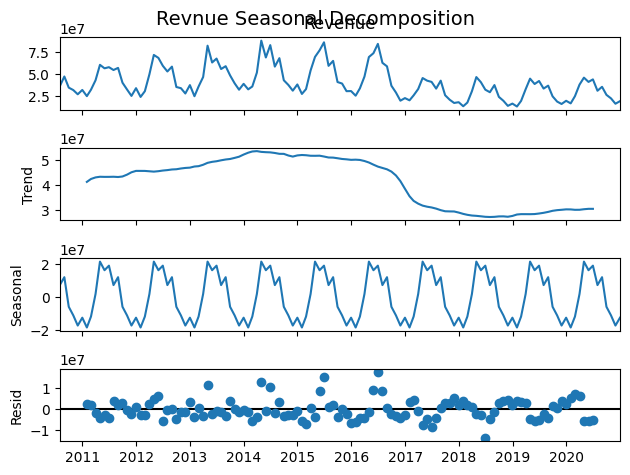

ADF Statistic: -0.6036, p-value: 0.8702
Series is non–stationary. Using first difference (d=1).

Fitting ARIMA(3,1,3)...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(3,1,3): RMSE=9386847.10, MAPE=42.67%, R²=0.41

Fitting Optimal non–seasonal ARIMA (auto_arima)...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4392.074, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4419.467, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4421.475, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4421.472, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4417.488, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4390.971, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4415.832, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4424.087, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4394.268, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4396.497, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4390.467, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4414.530, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4392.070, Time=0.15

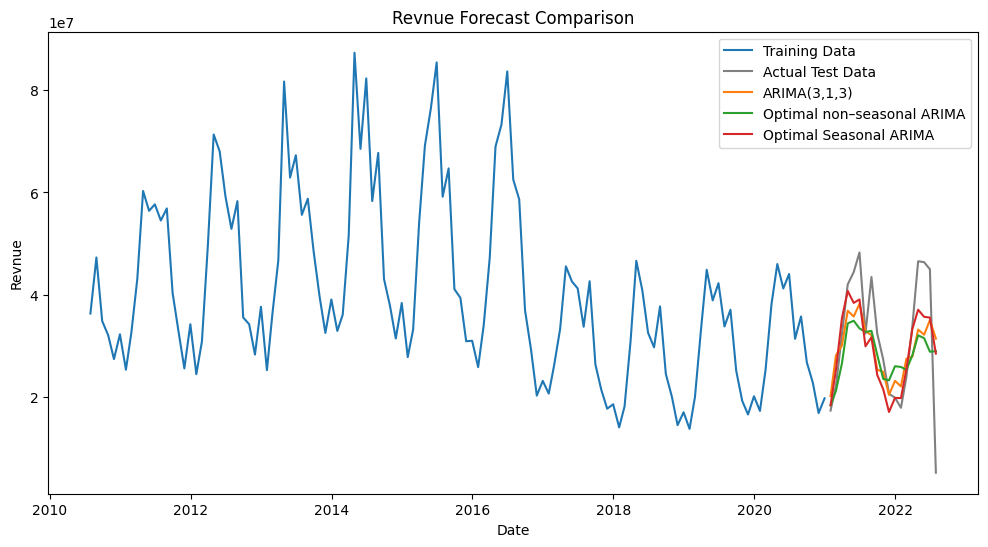

In [18]:
print("\n>>> Revenue ARIMA Forecasting")
metrics_sales = arima_forecasting("Revnue", train_revenue, test_revenue)